In [2]:
'''
Deep Learning
Assignment 1

The objective of this assignment is to learn about simple data curation practices, 
and familiarize you with some of the data we'll be reusing later.

This notebook uses the notMNIST dataset to be used with python experiments. 
This dataset is designed to look like the classic MNIST dataset, while looking
a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.
'''

"\nDeep Learning\nAssignment 1\n\nThe objective of this assignment is to learn about simple data curation practices, \nand familiarize you with some of the data we'll be reusing later.\n\nThis notebook uses the notMNIST dataset to be used with python experiments. \nThis dataset is designed to look like the classic MNIST dataset, while looking\na little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.\n"

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
import tarfile
from numpy import random
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline



In [4]:
'''First, we'll download the dataset to our local machine. The data consists of characters 
rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J'
(10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, 
it should be possible to train models quickly on any machine.'''

"First, we'll download the dataset to our local machine. The data consists of characters \nrendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J'\n(10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, \nit should be possible to train models quickly on any machine."

In [5]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [6]:
'''Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.'''

'Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.'

In [7]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [8]:
'''Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we
just downloaded. Hint: you can use the package IPython.display'''

"Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we\njust downloaded. Hint: you can use the package IPython.display"

In [9]:
'''#set path to directories where image data is stored
path_large='./notMNIST_large/' # train dataset
path_small='./notMNIST_small/'# test dataset

imgFiles_large = os.listdir(path_large)
imgFiles_small = os.listdir(path_small)


#iterate through small images
for i in range(0,3):
    random_index_path = random.randint(0,len(imgFiles_small))#in numpy the randint includes the last number        
    
    temp_path = path_small + imgFiles_small[random_index_path] #path to random directory
    temp_list_img = os.listdir(temp_path) #list all images of files within random directory    
       
    radom_index_img = random.randint(0,len(temp_list_img))
    
    #pick some random image
    final_path_image = temp_path +'/'+ temp_list_img[radom_index_img]
       
    print(final_path_image) #print final path  
        

    #image = mpimg.imread(final_path_image) #image from path
    #image_plot = plt.imshow(image)
    #plt.show()
    


#print(image_data)

'''

"#set path to directories where image data is stored\npath_large='./notMNIST_large/' # train dataset\npath_small='./notMNIST_small/'# test dataset\n\nimgFiles_large = os.listdir(path_large)\nimgFiles_small = os.listdir(path_small)\n\n\n#iterate through small images\nfor i in range(0,3):\n    random_index_path = random.randint(0,len(imgFiles_small))#in numpy the randint includes the last number        \n    \n    temp_path = path_small + imgFiles_small[random_index_path] #path to random directory\n    temp_list_img = os.listdir(temp_path) #list all images of files within random directory    \n       \n    radom_index_img = random.randint(0,len(temp_list_img))\n    \n    #pick some random image\n    final_path_image = temp_path +'/'+ temp_list_img[radom_index_img]\n       \n    print(final_path_image) #print final path  \n        \n\n    #image = mpimg.imread(final_path_image) #image from path\n    #image_plot = plt.imshow(image)\n    #plt.show()\n    \n\n\n#print(image_data)\n\n"

In [10]:
'''

Now let's load the data in a more manageable format. Since, depending on your computer setup 
you might not be able to fit it all in memory, we'll load each class into a separate dataset, 
store them on disk and curate them independently. Later we'll merge them into a single dataset 
of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, 
normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.
'''

"\n\nNow let's load the data in a more manageable format. Since, depending on your computer setup \nyou might not be able to fit it all in memory, we'll load each class into a separate dataset, \nstore them on disk and curate them independently. Later we'll merge them into a single dataset \nof manageable size.\n\nWe'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, \nnormalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.\n\nA few images might not be readable, we'll just skip them.\n"

In [11]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset


#pick images from folders
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

#save 3D datasets into *.pickle file
train_datasets = maybe_pickle(train_folders, 45000) #stores data sets in a single file per label
test_datasets = maybe_pickle(test_folders, 1800) #stores data sets in a single file per label

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

In [12]:
'''Let's verify that the data still looks good. Displaying a sample of the labels
and images from the ndarray. Hint: you can use matplotlib.pyplot.
'''

"Let's verify that the data still looks good. Displaying a sample of the labels\nand images from the ndarray. Hint: you can use matplotlib.pyplot.\n"

In [13]:
print(train_datasets) # just pick some random data set

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']


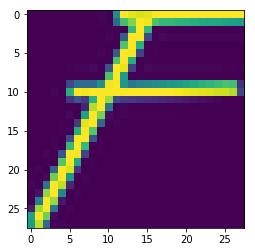

52912


In [14]:
fileObject = open(train_datasets[5],'rb') #open file in bynary reading mode
# load the object from the file into variable
testData = pickle.load(fileObject)  
#print(A_testData[1,:,:])
img = testData[3,:,:]
imgplot = plt.imshow(img)
plt.show()

print(testData.shape[0]) 
#close file after use, thank you
fileObject.close()


In [15]:
'''
Problem 3

Another check: we expect the data to be balanced across classes. Verify that.'''


'\nProblem 3\n\nAnother check: we expect the data to be balanced across classes. Verify that.'

In [16]:
'''Data set is balanced is when the std deviation of number of samples of classes 
is low and number of samples is close to mean'''

#empty helper array to store number of samples
num_samples = np.array([])

#open each class
for label_class in train_datasets:
    with open(label_class, 'rb') as fileObj:  # Use file to refer to the file object
        testData = pickle.load(fileObj) 
        curNumSamples = testData.shape[0]
    num_samples = np.append(num_samples, curNumSamples)

print (num_samples)
print ('Mean of samples', num_samples.mean()) #calculate mean
print ('SD of samples', np.std(num_samples)) #calculate std deviation

[52909. 52911. 52912. 52911. 52912. 52912. 52912. 52912. 52912. 52911.]
Mean of samples 52911.4
SD of samples 0.9165151389911681


In [17]:
'''
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.
'''



def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set) #impoertant!
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

         
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [18]:
'''
Randomizing data
'''

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)



In [19]:
'''Problem 4

Convince yourself that the data is still good after shuffling!'''

'Problem 4\n\nConvince yourself that the data is still good after shuffling!'

In [20]:
#maps labels to ids


labels ={}

for i,label_file in enumerate(train_datasets):
    labels[i] = label_file[17]; # on 17th position is the label letter we need

print(labels)


{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}


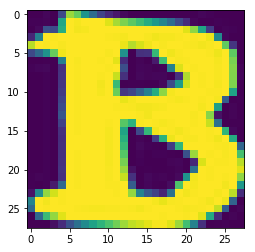

1


In [21]:
#input manually diverse indexes to get sure that label corresponds to correct letter

img = train_dataset[700,:,:]
imgplot = plt.imshow(img)
plt.show()

print (train_labels[700])

In [22]:
'''save resulting data as a new pickle file'''

pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [51]:
#open pickle file with saved datasets
data_root = '.'
DataSet_Path = os.path.join(data_root, 'notMNIST.pickle')

try:
    DataSet_File = open(DataSet_Path,'rb')
    Data = pickle.load(DataSet_File) 
except Exception as e:
  print('Unable to open', DataSet_Path, ':', e)
  raise

#dataset is saved as dictionary to pickle file     

#print(dataset)

train_dataset = Data ['train_dataset'];
train_labels = Data ['train_labels'];

#check if import was ok
print ('train_dataset shape ', train_dataset.shape)
print ('train_labels shape ', train_labels.shape)

cv_dataset = Data ['valid_dataset'];
cv_labels = Data ['valid_labels'];

#check if import was ok
print ('cv_dataset shape ', cv_dataset.shape)
print ('cv_labels shape ', cv_labels.shape)

test_dataset = Data ['test_dataset'];
test_labels = Data ['test_labels'];

#check if import was ok
print ('test_dataset shape ', test_dataset.shape)
print ('test_labels shape ', test_labels.shape)

#routine can be implemented to automatically check the data if needed

print(type(train_dataset))

train_dataset shape  (200000, 28, 28)
train_labels shape  (200000,)
cv_dataset shape  (10000, 28, 28)
cv_labels shape  (10000,)
test_dataset shape  (10000, 28, 28)
test_labels shape  (10000,)
<class 'numpy.ndarray'>


In [57]:
'''my computer is too slow so I reduce the amount of samples'''

def reduce_dataset(orig_dataset, samples_limit):
    '''
    Reduces amount of sample images
    '''
    reduced_dataset = np.delete(orig_dataset, range(samples_limit,np.size(orig_dataset,0)), 0);
    
    return reduced_dataset;

train_dataset_50 = reduce_dataset(train_dataset, 50);
train_dataset_100 = reduce_dataset(train_dataset, 100);
train_dataset_1000 = reduce_dataset(train_dataset, 1000);

train_labels_50 = reduce_dataset(train_labels, 50);
train_labels_100 = reduce_dataset(train_labels, 100);
train_labels_1000 = reduce_dataset(train_labels, 1000);

cv_dataset_50 = reduce_dataset(cv_dataset, 50);
cv_dataset_100 = reduce_dataset(cv_dataset, 100);
cv_dataset_1000 = reduce_dataset(cv_dataset, 1000);

cv_labels_50 = reduce_dataset(train_labels, 50);
cv_labels_100 = reduce_dataset(train_labels, 100);
cv_labels_1000 = reduce_dataset(train_labels, 1000);

test_dataset_50 = reduce_dataset(test_dataset, 50);
test_dataset_100 = reduce_dataset(test_dataset, 100);
test_dataset_1000 = reduce_dataset(test_dataset, 1000);

test_labels_50 = reduce_dataset(train_labels, 50);
test_labels_100 = reduce_dataset(train_labels, 100);
test_labels_1000 = reduce_dataset(train_labels, 1000);


In [63]:
'''
Problem 5

By construction, this dataset might contain a lot of overlapping samples, 
including training data that's also contained in the validation and test set! 
Overlap between training and test can skew the results if you expect to use your model in 
an environment where there is never an overlap, but are actually ok if you expect to see training 
samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

    What about near duplicates between datasets? (images that are almost identical)
    Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
'''

#to find overlap it is needed to compare images with same labels pixel by pixel -> if 100% match then identical
#Measure how much overlap there is between training, validation and test samples: num_overlaps/num_samples_dataset


def find_duplicates(train_dataset,compared_set):
    '''function finds duplicates
    train_dataset: reference set
    compared_set: elements where duplicates to reference are searched for
    '''  
    duplicates =[];#helper array where duplicate indexes of compared_set shall be stored   
    

    #iterate through each training image  
    for i in range(np.size(train_dataset,0)):
        train_img = train_dataset[i,:,:];
        #iterate through each cv image
        for k in range(np.size(compared_set,0)):        
            compared_img = compared_set[k,:,:];
            #substract current both images
            cur_dif = train_img - compared_img;
            #images identical?
            if np.all(cur_dif == np.zeros((28,28))):            
                duplicates.append(k);
            
    return duplicates;

def remove_duplicates(dataset,labels,duplicates):
    '''function removes all duplicates
    dataset: target dataset
    labels: also remove labels corresponding to dupolicates
    duplicates: list of image indexes that are duplicates within target dataset
    '''
    clean_dataset = np.delete(dataset, duplicates, 0);
    clean_labels = np.delete(labels, duplicates, 0);
    
    print('removed ',len(duplicates), ' duplicates')
    
    return clean_dataset, clean_labels;

        
duplicates_with_cv = find_duplicates(train_dataset_50, cv_dataset_50)
duplicates_with_test = find_duplicates(train_dataset_50, test_dataset_50)


clean_cv_dataset, clean_cv_labels =  remove_duplicates(cv_dataset_50,cv_labels_50,duplicates_with_cv);
clean_test_dataset, clean_test_labels =  remove_duplicates(test_dataset_50,test_labels_50,duplicates_with_test);


# What about near duplicates between datasets? (images that are almost identical) -> use correlation

#    Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
# -> delete duplicates


removed  0
removed  0


In [64]:
'''
Problem 6

Let's get an idea of what an off-the-shelf classifier can give you on this data.
It's always good to check that there is something to learn, and that it's a problem that 
is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 
Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!'''

print('Implement logistic regression')


Implement logistic regression
